In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
from numpy import zeros
import re # regular expression
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# для нормализации, стандартизации
from sklearn import preprocessing

# импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# импортируем модуль geopy для определения географического полодения
from functools import partial
from geopy.geocoders import Nominatim
from geopy import distance

import nltk   # Natural Language Toolkit module
from nltk.sentiment.vader import SentimentIntensityAnalyzer # Sentiment Analyzer
import ssl # ssl module

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# статистические тесты оценки значимости признаков
from sklearn.feature_selection import chi2 # хи-квадрат
from sklearn.feature_selection import f_classif # тест anova

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('data/sf-booking'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/home/kostritsky/.local/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


data/sf-booking/hotels_train.csv
data/sf-booking/submission.csv
data/sf-booking/hotels_test.csv


In [2]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [4]:
# Подгрузим наши данные из соревнования

DATA_DIR = 'data/sf-booking/'
df_train = pd.read_csv(DATA_DIR+'/hotels_train.csv') # датасет для обучения
df_test = pd.read_csv(DATA_DIR+'hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv(DATA_DIR+'/submission.csv') # самбмишн

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [6]:
df_train.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097


In [7]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [8]:
sample_submission.head(2)

,reviewer_score,id
0,1,488440
1,10,274649


In [9]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   reviewer_score  128935 non-null  int64
 1   id              128935 non-null  int64
dtypes: int64(2)
memory usage: 2.0 MB


In [10]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

# 1. Заполнение пропущенных значений
Пропущенные значения имеются только в столбцах `lat` и `lng`. 
Проверяем можно ли их заполнить, на основе того, что этот отель уже упоминается в отзывах и при этом долгота и широта уже указаны правильно?

In [11]:
# заполняем пропуски самым простым способом - устанавливая нулевые значения
data['lat'] = data['lat'].fillna(0)
data['lng'] = data['lng'].fillna(0)

In [12]:
# Сформируем список уникальных названий отелей
hotel_unique_name = set(list(data['hotel_name']))
if len(hotel_unique_name) == data['hotel_name'].nunique():
    print(len(hotel_unique_name))
else:
    print('???')
    
# Определим названия отелей, у которых одна из координат lat или lng равна 0
nan_coordinates = []
# Отели, у которых есть несколько координат
few_coordinates = []

for h_name in hotel_unique_name:
    tt = set(list(zip(list(data[data['hotel_name']==h_name]['lat']),
            list(data[data['hotel_name']==h_name]['lng']))))
    if len(tt) > 1:
        few_coordinates.append(h_name)
    else:
        if (list(tt)[0][1]==0) or (list(tt)[0][1]==0):
            nan_coordinates.append(h_name)

#print(f'Отели с несколькими координатами:\n {few_coordinates}')
#print(f'Отели с пропущенными координатами:\n {nan_coordinates}')

# Проверим попали ли отели, имеющие несколько адресов, в список с утерянными координатами?
count = 0
for h_name_few in few_coordinates:
    if h_name_few in nan_coordinates:
        count += 1
        print(f'The {h_name} hotel has lost latitude and longitude')
        
print(f'The number of hotels, which have few addresses and have lost coordinates is {count}')

1492
The number of hotels, which have few addresses and have lost coordinates is 0


**Выводы:**
1. Только в одном случае несколько отелей, имеющих разные адреса и координаты, имеют одно название.
2. Отелей, у которых пропущены координаты (долгота, широта) - 17 шт. Каждый их них имеет свой уникальный адрес.
3. Все отели с несколькими адресами имеют долготу и широту.

Попробуем восстановить долготу и широту у отелей, их не имеющих, по названию отеля и его адресу, воспользовавшись модулем [geopy](https://geopy.readthedocs.io/en/stable/).

In [13]:
# Определим объект geolocator сервиса Nominatim
geolocator = Nominatim(user_agent="hotel_score_predictor")
geocode = partial(geolocator.geocode, language="en")

# попытаемся найти пропущенные координаты отеля и его адрес
# по названию отеля, индексу, названию города и страны
lost_coordinates = []   # список потерянных координат

for item in nan_coordinates:
    hotel_address = str(set(list(data[data['hotel_name']==item]['hotel_address']))).split()
    if item == 'Mercure Paris Gare Montparnasse':
        location = geolocator.geocode('Mercure Paris'+' '+' '.join(hotel_address[-3:-1]))
        coordinates = (location.latitude,location.longitude)
    elif item == 'Hotel Daniel Vienna':
        location = geolocator.geocode(item)
        coordinates = (location.latitude,location.longitude)
    elif item == 'Derag Livinghotel Kaiser Franz Joseph Vienna':
        location = geolocator.geocode('Kaiser Franz Joseph'+' '+' '.join(hotel_address[-3:-1]))
        coordinates = (location.latitude,location.longitude)
    elif item == 'Austria Trend Hotel Schloss Wilhelminenberg Wien':
        location = geolocator.geocode('Austria Trend Hotel'+' '+' '.join(hotel_address[-3:-1]))
        coordinates = (location.latitude,location.longitude)
        print(coordinates)
    elif item == 'Hotel Advance':
        coordinates = (41.38337532731557, 2.162971056490655)  # определено вручную по GoogleMaps
    elif item == 'Fleming s Selection Hotel Wien City':
        coordinates = (48.20946322743687, 16.353445498926963)  # определено вручную по GoogleMaps
    elif item == 'Maison Albar Hotel Paris Op ra Diamond':
        location = geolocator.geocode('Maison Albar Hotel'+' '+' '.join(hotel_address[-3:-1]))
        coordinates = (location.latitude,location.longitude)        
    elif item == 'City Hotel Deutschmeister':
        location = geolocator.geocode('City Hotel'+' '+' '.join(hotel_address[-3:-1]))
        coordinates = (location.latitude,location.longitude)
    elif item == 'Hotel Pension Baron am Schottentor':
        coordinates = (48.21694255447111, 16.359927156596825)  # определено вручную по GoogleMaps
    else:
        location = geolocator.geocode(item+' '+' '.join(hotel_address[-3:-1]))
        coordinates = (location.latitude,location.longitude)

    lost_coordinates.append(coordinates)

# Создаем словарь с восстановленными координатами
recovered_coordinates = dict(list(zip(nan_coordinates,lost_coordinates)))

# Создаем функцию для замены столбцов lat и lng
def repl_coord(row,col):
#   row - строка DataFrame
#   col - название столбца для замены
#   nan_coordinates - список отелей, у которых заменяем lng или lng
#   recovered_coordinates - словарь, содержащий новые координаты отелей
#                           keys - названия отелей
#                           values - кортеж (lat, lng)

    if row['hotel_name'] in nan_coordinates:
        if col == 'lat':
            return recovered_coordinates[row['hotel_name']][0]
        elif col == 'lng':
            return recovered_coordinates[row['hotel_name']][1]
    else:
        return row[col]

# производим восстановление утерянных координат
data['lat']  = data.apply(repl_coord, axis=1, args=['lat'])
data['lng']  = data.apply(repl_coord, axis=1, args=['lng'])

(48.2273038, 16.4002304)


# 2. Создаем новые признаки

## 2.1 Признаки на основе lat и lng

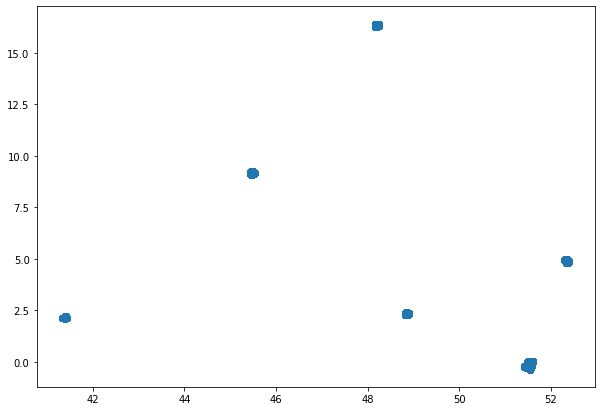

In [14]:
# Зададим размер отображаемого рисунка
fig = plt.figure(figsize=(10, 7))

lat_vs_lng = plt.scatter(data=data, x='lat', y='lng')

**Вывод:**
Из диаграммы рассеяния видно, что пары широта-долгота группируются вокруг шести кластеров, которые, скорее всего соответствуют названиям городов, в которых находятся отели. 

Проверим это. Для этого определим из признака `hotel address` название страны и города, в котором расположен отель, и занесем их в новые признаки.

Создадим признак, содержащий расстояние от отеля до центра города

In [15]:
# определим город и страну размещения отеля

data['Country'] = data['hotel_address'].apply(lambda x: x.split(' ')[-1] if x.split(' ')[-1] != 'Kingdom' else 'United Kingdom')
data['City'] = data['hotel_address'].apply(lambda x: x.split(' ')[-2] if x.split(' ')[-1] != 'Kingdom' else x.split(' ')[-5])

city_center = dict()  # словарь с координатами центра города

#  Создадим цикл по всем уникальным городам, в которых находятся отели
for name in tuple(data['City'].value_counts().keys()):
    location = geolocator.geocode(name)                         # координаты центра города
    city_center[name]=(location.latitude, location.longitude)   # добавляем координаты в словарь
    

# Создаем признак в который помещаем расстояние от центра города до отеля с точностью до метра
data['distance_from_center'] = data.apply(lambda x: round(distance.distance(city_center[x['City']], (x['lat'],x['lng'])).km, 3), axis=1)


## 2.2 Переведем признак `days_since_review` из типа `object` в `int`

In [16]:
data['days_since_review'] = data['days_since_review'].apply(lambda x: int(x.split(' ',2)[0]))
#data['days_since_review'].hist()

## 2.3 Признаки на основе review_date

Переведем признак `review_date` в формат datetime и попробуем сконструировать новые принаки на основе него: месяц, время года, квартал.
Проверим какой из признаков более всего влияет на результат задачи.

# 

In [17]:
# преобразуем признак review_date в формат datetime
data['review_date'] = pd.to_datetime(data['review_date'])

data['review_month'] = data['review_date'].dt.month
data['review_dow'] = data['review_date'].dt.dayofweek

## 2.4 Проверим насколько влияет национальность рецензента на оценку отеля

1. Создадим числовой признак национальности, содержащий 14 самых распространенных национальностей рецензентов. Остальные национальности пометим значением `other`.
2. Создадим бинарный признак, проверяющий совпадает ли национальность рецензента со страной размщения отеля?

In [18]:
# определим список 10 наиболее распространенных национальностей рецензентов
N_NATION = 10  # кол-во национальностей, которое будем учитывать в признаке
largest_nationality_list = [val[1:-1] for val in list(data['reviewer_nationality'].value_counts().nlargest(N_NATION).keys())]

# переопределим признак reviewer_nationality, в который будут записаны 14 наиболее распространенных национальностей, 
# остальные отнесены к 'other'
data['revwr_nation'] = data['reviewer_nationality'].apply(lambda x: x[1:-1] if x[1:-1] in largest_nationality_list else 'other')

# выполним OneHot кодирование для признака reviewer_nationality
data = pd.get_dummies(data=data, columns=['revwr_nation'])

**Вывод:** к сожалению, видно, что сама по себе национальность рецензента очень незначительно влияет на результат.

## 2.5 Сравним национальность рецензента и страну размещения отеля

In [19]:
# избавимся от лишних пробелов в признаке reviewer_nationality
data['reviewer_nationality'] = data['reviewer_nationality'].apply(lambda x: x[1:-1])
# создадим новый признак, отмечающий является ли рецензент жителем страны, в которой расположен отель
data['is_domestic_hotel'] = data.apply(lambda x: 1 if x['reviewer_nationality']==x['Country'] else 0, axis=1)

## 2.6 Работаем с текстом отзыва. 

Для этого посредством  [Natural Language Toolkit](https://www.nltk.org/) определим степень положительности и отрицательности отзыва респондента.

In [20]:
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context
    
nltk.downloader.download('vader_lexicon')

sent_analyzer = SentimentIntensityAnalyzer()

data['pos_review_comp_score'] = data['positive_review'].apply(lambda x: sent_analyzer.polarity_scores(x)['compound'] if x != 'No Positive' else 0)
data['pos_review_neg_score'] = data['positive_review'].apply(lambda x: sent_analyzer.polarity_scores(x)['neg'] if x != 'No Positive' else 0)
data['pos_review_neu_score'] = data['positive_review'].apply(lambda x: sent_analyzer.polarity_scores(x)['neu'] if x != 'No Positive' else 1)
data['pos_review_pos_score'] = data['positive_review'].apply(lambda x: sent_analyzer.polarity_scores(x)['pos'] if x != 'No Positive' else 0)

data['neg_review_comp_score'] = data['negative_review'].apply(lambda x: sent_analyzer.polarity_scores(x)['compound'] if x != 'No Negative' else 0)
data['neg_review_neg_score'] = data['negative_review'].apply(lambda x: sent_analyzer.polarity_scores(x)['neg'] if x != 'No Negative' else 0)
data['neg_review_neu_score'] = data['negative_review'].apply(lambda x: sent_analyzer.polarity_scores(x)['neu'] if x != 'No Negative' else 1)
data['neg_review_pos_score'] = data['negative_review'].apply(lambda x: sent_analyzer.polarity_scores(x)['pos'] if x != 'No Negative' else 0)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/kostritsky/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## 2.7 Работаем с TAGS

Попробуем определить наиболее часто встречающиеся `TAG` и создать для каждого из них свой категориальный признак.
Для остальные `TAGS` отметив в признаке `other_tags`.

In [21]:
# Определим 50 наиболее встречающихся тэгов

# Получим множество тэгов, употреблявшихся в отзывах
all_tags = set()  # создадим множество с выделенными тэгами
# создаем регулярное выражение для выделения из признака TAGS строки с названиями тэгов
p = re.compile(r"^\[.+\]$")  

for val in data['tags']:
    s1 = p.findall(val)  # получаем строку, содержащую только названия tags
    # получаем список с названиями тэгов и добавляем его в множество обнаруженных тэгов
    all_tags |= set([s1_splitted[2:-2] for s1_splitted in re.split(r'[,]\s*', s1[0][1:-1])])

# на основе полученного множества создадим словарь, в котором
# ключами являются названия тэгов, а значениями - кол-во употреблений этого тэга в отзывах
keys = tuple(all_tags)              # кортеж с ключами
values = zeros(len(keys))           # массив с значениями, равными 0
tags_dict = dict(zip(keys, values))  # словарь с нулевыми значениями

# Определяем кол-во употреблений каждого тэга в наших данных 
# и заносим его в созданный словарь tags_dict
for val in data['tags']:
    s1 = p.findall(val)
    tag_list = [s1_splitted[2:-2] for s1_splitted in re.split(r'[,]\s*', s1[0][1:-1])]
    for tag_val in tag_list:
        tags_dict[tag_val] += 1


# Создаем список из N_TAGS наиболее часто встречающихся tags
N_TAGS = 14   # число наиболее часто встречающихся признаков

# создаем из словаря серию, у которой 
# индексы - название tag, значение - кол-во употреблений этого tag в отклике
tags_series = pd.Series(tags_dict)
frequent_tags = tags_series.nlargest(N_TAGS).keys()

# Создаем признак other_tags, содержащий 0 во всех строчках
data['other_tags'] = data['tags'].apply(lambda x: 0)

# Создадим признаки для каждого из наиболее встречающихся tags
for item in frequent_tags:
    # значение признака = 1, если признак найден в списке tags. Иначе - 0
    data[item] = data['tags'].apply(lambda x: 1 if x.find(item)>=0 else 0)
    # суммируем в other_tags количество найденных значений из frequent_tags  
    data['other_tags'] +=  data[item]

# в other_tags отмечаем только те признаки, которые не входят в число частых
data['other_tags'] = data['other_tags'].apply(lambda x: 1 if x==0 else 0)

Создадим порядковый признак `NUMBER_NIGHTS`, содержащий информацию о том, сколько ночей провел рецензент в отеле

<AxesSubplot:>

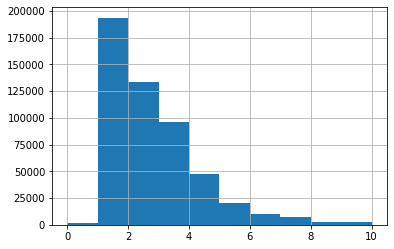

In [22]:
night_number = [
    'Stayed 1 night', 
    'Stayed 2 nights',
    'Stayed 3 nights',
    'Stayed 4 nights',
    'Stayed 5 nights',
    'Stayed 6 nights',
    'Stayed 7 nights',
    'Stayed 8 nights',
    'Stayed 9 nights',
    'Stayed 10 nights'
    ]

def search_in_tags(tags, *args):
    for indx in range(len(args)):
        if tags.find(args[indx])>=0:
            return indx+1
    return 0

data['number_nights'] = data['tags'].apply(search_in_tags, args=night_number)

data['number_nights'].hist()

# 3. Отбор признаков

Выполним оценку значимости каждого признака для целевой переменной — рейтинг отеля.

Для оценки значимости категориальных признаков будем использовать тест хи-квадрат, для непрерывных признаков — тест ANOVA.

<AxesSubplot:title={'center':'Распределение категориальных признаков по значимости для рейтинга отеля'}, ylabel='chi2'>

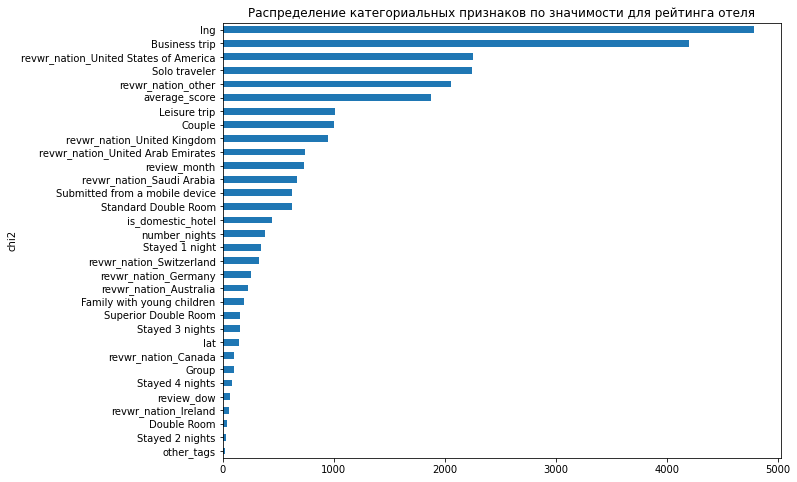

In [23]:
# Также выделим все категориальные признаки в свой список
cat_cols = [
    'average_score',
    'lat',
    'lng',
    'review_month',
    'review_dow',
    'number_nights',
    'revwr_nation_Australia',
    'revwr_nation_Canada',
    'revwr_nation_Germany',
    'revwr_nation_Ireland',
    'revwr_nation_Saudi Arabia',
    'revwr_nation_Switzerland',
    'revwr_nation_United Arab Emirates',
    'revwr_nation_United Kingdom',
    'revwr_nation_United States of America',
    'revwr_nation_other',
    'is_domestic_hotel',
    'other_tags',
    'Leisure trip',
    'Submitted from a mobile device',
    'Couple',
    'Stayed 1 night',
    'Stayed 2 nights',
    'Solo traveler',
    'Stayed 3 nights',
    'Business trip', 
    'Group',
    'Family with young children', 
    'Stayed 4 nights', 
    'Double Room',
    'Standard Double Room', 
    'Superior Double Room'
    ]

# Создадим целевую переменную для рассчета численных парамеиров тестов
y = data['reviewer_score']
y = y.astype('int')

data['lng'] = data['lng'].apply(lambda x: abs(x)) # chi2 принимает только положительные величины
imp_cat = pd.Series(chi2(data[cat_cols], y)[0], index=cat_cols) # рассчитаем chi2 и p-value для каждого признака 
imp_cat.sort_values(inplace = True) # сортируем в порядке убывания chi2
# выводим bar-plot с chi2
imp_cat.plot(kind = 'barh', 
            figsize=(10,8), 
            ylabel='chi2', 
            title='Распределение категориальных признаков по значимости для рейтинга отеля') 

<AxesSubplot:title={'center':'Распределение непрерывных признаков по значимости для рейтинга отеля'}, ylabel='f-статистика'>

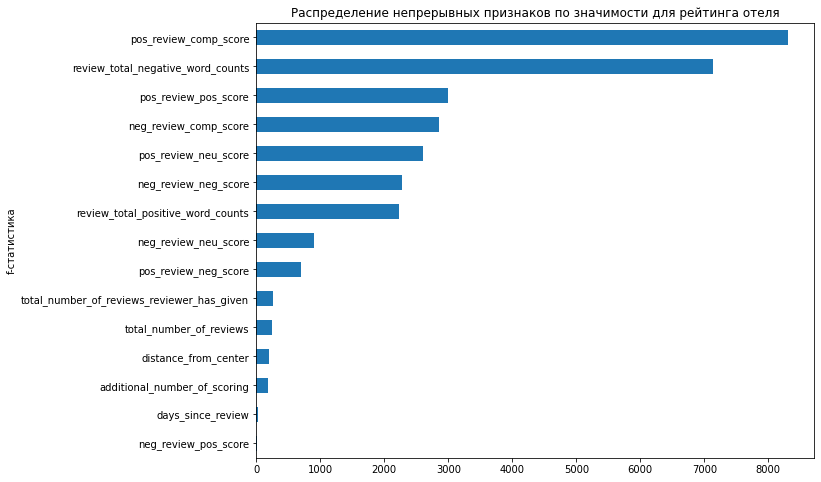

In [24]:
# Выделим все непрерывные признаки в отдельный список
num_cols = [
    'total_number_of_reviews',
    'review_total_negative_word_counts',
    'additional_number_of_scoring',
    'review_total_positive_word_counts',
    'total_number_of_reviews_reviewer_has_given',
    'days_since_review',
    'distance_from_center',
    'pos_review_comp_score', 
    'pos_review_neg_score',
    'pos_review_neu_score', 'pos_review_pos_score', 'neg_review_comp_score',
    'neg_review_neg_score', 'neg_review_neu_score', 'neg_review_pos_score'
    ]

imp_num = pd.Series(f_classif(data[num_cols], y)[0], index = num_cols) # массив f-статистик и p-value для каждого признака
imp_num.sort_values(inplace = True) # сортируем в порядке убывания f-статистики

imp_num.plot(kind = 'barh',
            figsize=(10,8),
            ylabel='f-статистика', 
            title='Распределение непрерывных признаков по значимости для рейтинга отеля') 

Из приведенных распределений можно заключить, что следующие признаки слабо влияют на рейтинг отелей:
- days_since_review
- neg_review_pos_score
- other_tags
- 'Stayed 2 nights'
- 'Double Room'

Попробуем исключить их из набора данных, предназначенного для обучения.

In [25]:
# Удаляем признаки, слабо влияющие на рейтинг отеля
data.drop([
    'days_since_review',
    'neg_review_pos_score',
    'other_tags',
    'Stayed 2 nights',
    'Double Room'
    ], axis = 1, inplace=True)

__Комментарии и выводы:__
После удаления вышеуказанных признаков метрика MAPE изменилась с 0.12485 до 0.12486, т.е. менее чем на 0.1%. Это подтверждает гипотезу о том, что данные признаки были малозначащими. Следовательно они могут быть удалены. 

Проведем анализ мультиколлиниарности признаков. 
Дл этого построим тепловую карту матрицы корреляций

<AxesSubplot:>

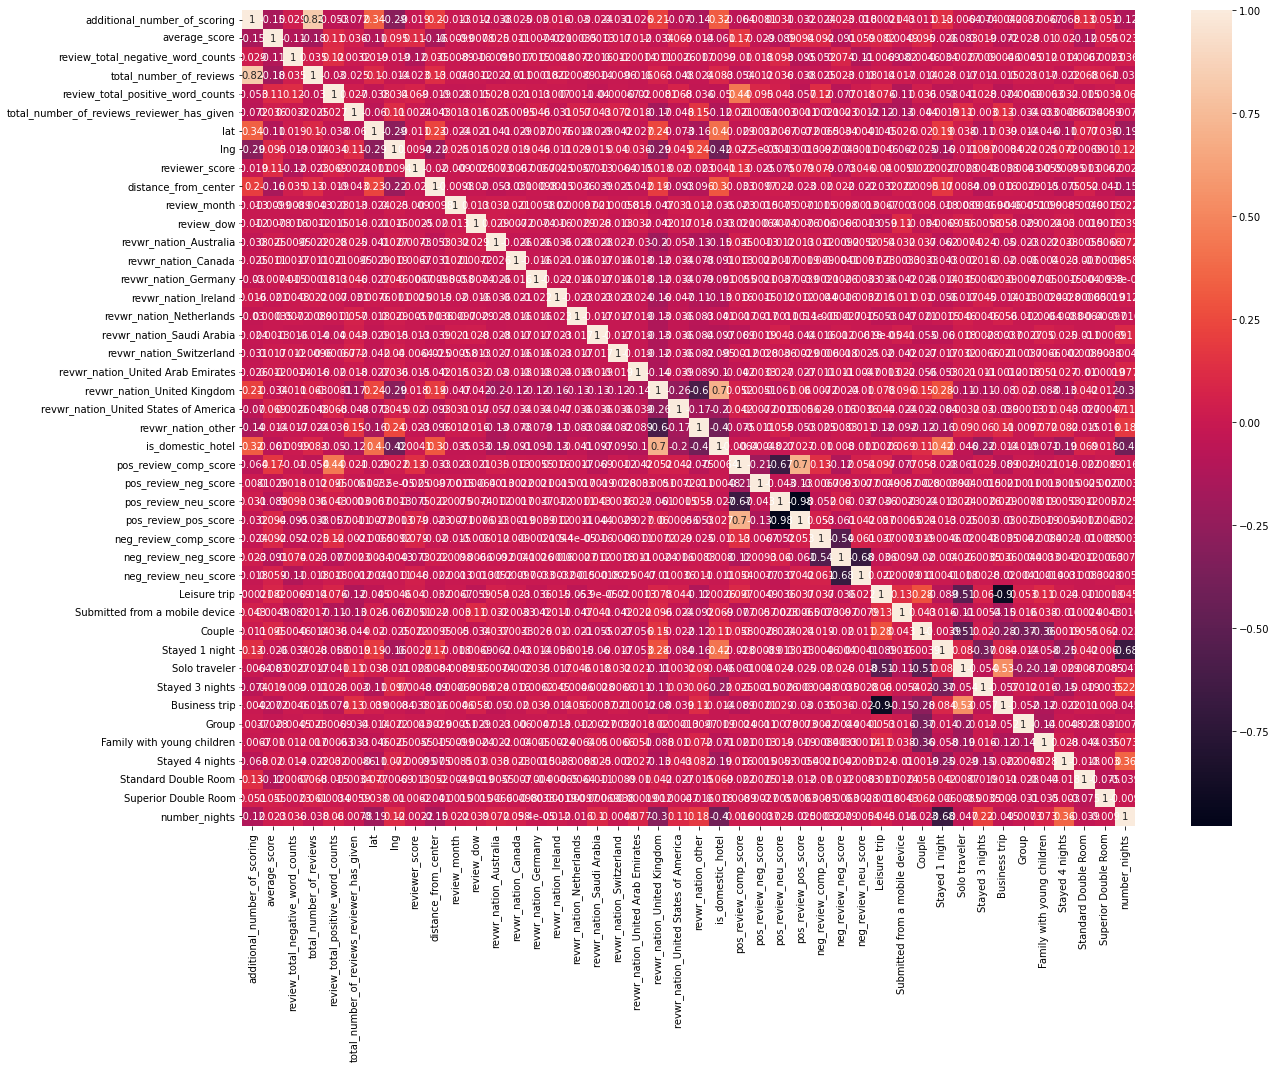

In [26]:
plt.rcParams['figure.figsize'] = (20,15)
sns.heatmap(data.drop(['sample'], axis=1).corr(), annot=True)

Удалим ряд признаков, которые имеют высокую корреляцию. Из пары признаков, котрая имеет высокую корреляцию будем удалять тот, который имеет меньшее влияние на рейтинг отелей.

In [27]:
data.columns

Index(['hotel_address', 'additional_number_of_scoring', 'review_date',
       'average_score', 'hotel_name', 'reviewer_nationality',
       'negative_review', 'review_total_negative_word_counts',
       'total_number_of_reviews', 'positive_review',
       'review_total_positive_word_counts',
       'total_number_of_reviews_reviewer_has_given', 'tags', 'lat', 'lng',
       'sample', 'reviewer_score', 'Country', 'City', 'distance_from_center',
       'review_month', 'review_dow', 'revwr_nation_Australia',
       'revwr_nation_Canada', 'revwr_nation_Germany', 'revwr_nation_Ireland',
       'revwr_nation_Netherlands', 'revwr_nation_Saudi Arabia',
       'revwr_nation_Switzerland', 'revwr_nation_United Arab Emirates',
       'revwr_nation_United Kingdom', 'revwr_nation_United States of America',
       'revwr_nation_other', 'is_domestic_hotel', 'pos_review_comp_score',
       'pos_review_neg_score', 'pos_review_neu_score', 'pos_review_pos_score',
       'neg_review_comp_score', 'neg_review_

In [28]:
# Удаляем признаки, имеющие высокую корреляцию
data.drop([
    'additional_number_of_scoring',
    'revwr_nation_United Kingdom',
    'pos_review_neu_score',
    'Leisure trip',
    'Stayed 1 night',
    'neg_review_neu_score'
    ], axis = 1, inplace=True)

<AxesSubplot:>

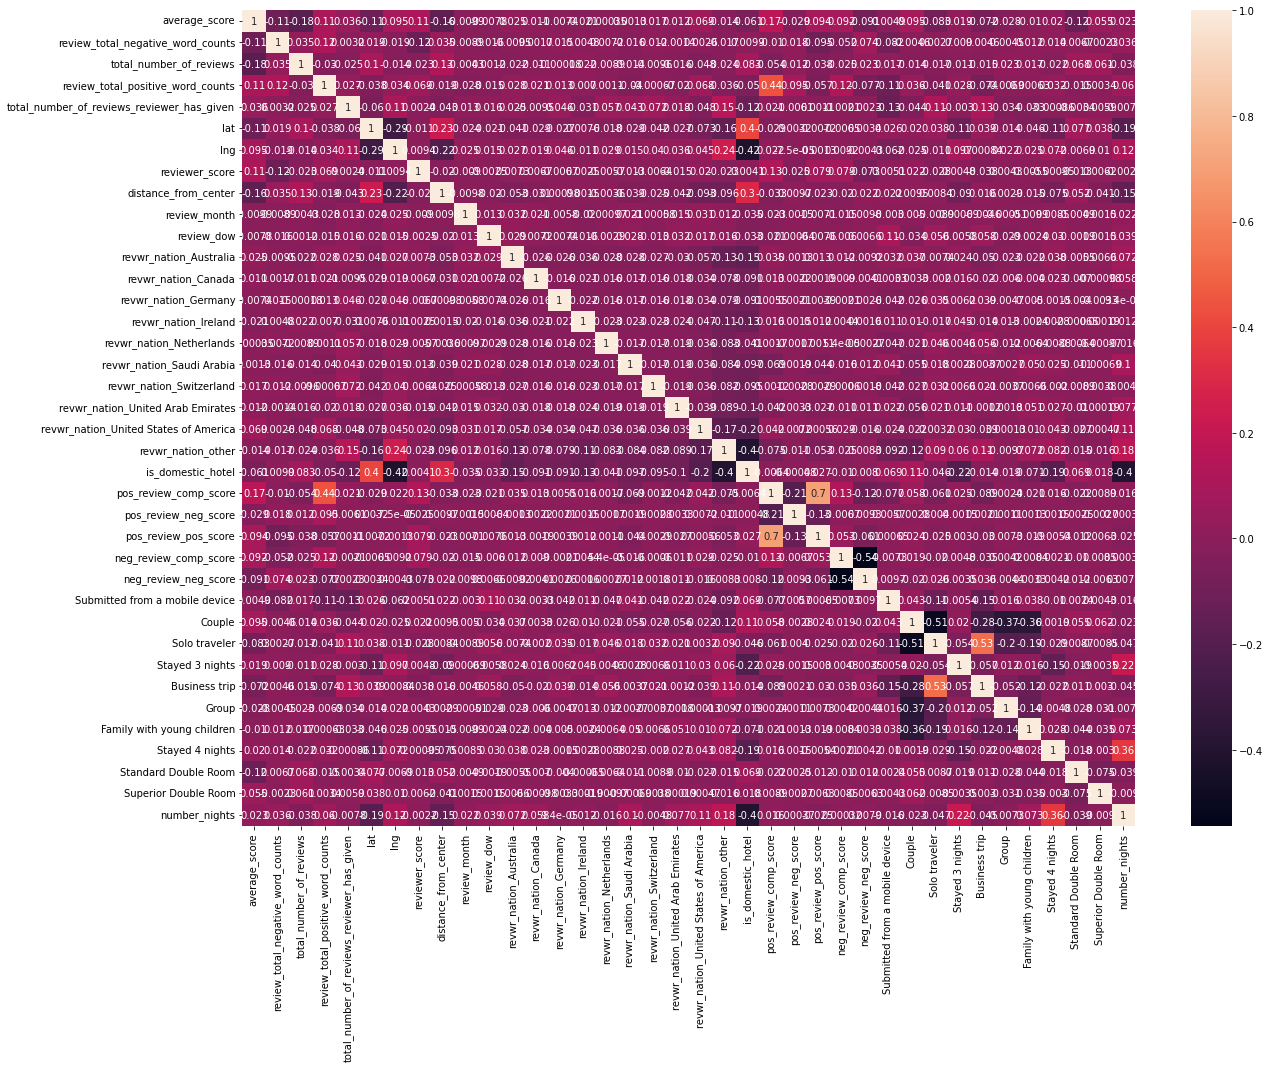

In [29]:
plt.rcParams['figure.figsize'] = (20,15)
sns.heatmap(data.drop(['sample'], axis=1).corr(), annot=True)

**Комментарии и выводы:**
Удаление признаков, которые имеют большую корреляцию привело к увеличению метрики MAPE с 0.12490 до 0.12500, т.е. менее чем на 0.1%. Т.е. у улучшению точности предсказания рейтинга отеля это не привело.

# **4. НОРМАЛИЗАЦИЯ ПРИЗНАКОВ**

Проведем нормализацию ряда признаков

In [30]:
# для этого создадим экземпляр класса MinMaxScaler
mm_scaler = preprocessing.MinMaxScaler()

# выполним нормализацию признаков 
scaled_array = mm_scaler.fit_transform(data[[
    'average_score',
    'review_total_negative_word_counts',
    'total_number_of_reviews',
    'review_total_positive_word_counts',
    'total_number_of_reviews_reviewer_has_given',
    'distance_from_center',
    'review_month',
    'review_dow',
    'number_nights'
    ]])
# создаем DataFrame с признаками, имеющими нормализованные значения
data_scaled = pd.DataFrame(scaled_array, columns=[
    'average_score_scaled',
    'review_total_negative_word_counts_scaled',
    'total_number_of_reviews_scaled',
    'review_total_positive_word_counts_scaled',
    'total_number_of_reviews_reviewer_has_given_scaled',
    'distance_from_center_scaled',
    'review_month_scaled',
    'review_dow_scaled',
    'number_nights_scaled'
    ])

# Объединяем таблицы по столбцам
data = pd.concat([data, data_scaled], axis=1, copy=False)

# Удаляем вспомогательные признаки
data.drop([
    'average_score',
    'review_total_negative_word_counts',
    'total_number_of_reviews',
    'review_total_positive_word_counts',
    'total_number_of_reviews_reviewer_has_given',
    'distance_from_center',
    'review_month',
    'review_dow',
    'number_nights'
    ], axis = 1, inplace=True)

In [31]:
data.nunique(dropna=False)

hotel_address                                          1493
review_date                                             731
hotel_name                                             1492
reviewer_nationality                                    227
negative_review                                      330011
positive_review                                      412601
tags                                                  55242
lat                                                    1489
lng                                                    1489
sample                                                    2
reviewer_score                                           38
Country                                                   6
City                                                      6
revwr_nation_Australia                                    2
revwr_nation_Canada                                       2
revwr_nation_Germany                                      2
revwr_nation_Ireland                    

In [32]:
# убираем признаки которые еще не успели обработать, 
# модель на признаках с dtypes "object" обучаться не будет, просто выберем их и удалим
object_columns = [s for s in data.columns if data[s].dtypes == 'object']
data.drop(object_columns, axis = 1, inplace=True)

# удалим признак review_date, который имеет тип datetime
data.drop('review_date', axis = 1, inplace=True)

In [33]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 39 columns):
 #   Column                                             Non-Null Count   Dtype  
---  ------                                             --------------   -----  
 0   lat                                                515738 non-null  float64
 1   lng                                                515738 non-null  float64
 2   sample                                             515738 non-null  int64  
 3   reviewer_score                                     515738 non-null  float64
 4   revwr_nation_Australia                             515738 non-null  uint8  
 5   revwr_nation_Canada                                515738 non-null  uint8  
 6   revwr_nation_Germany                               515738 non-null  uint8  
 7   revwr_nation_Ireland                               515738 non-null  uint8  
 8   revwr_nation_Netherlands                           515738 non-null  uint8 

In [34]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

In [35]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [36]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 38), (386803, 38), (386803, 37), (309442, 37), (77361, 37))

In [37]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [38]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [39]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   43.7s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.6s finished


In [40]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

#MAE: 0.9822361453527128
#MAPE: 0.14134806134259834

MAE: 0.8762178136701091
MAPE: 0.12501449034615122


<AxesSubplot:>

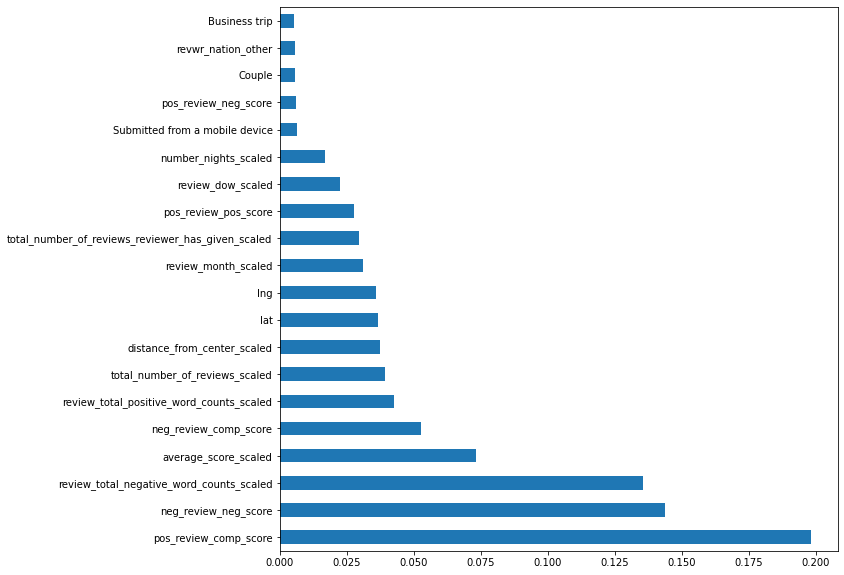

In [41]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')

In [42]:
test_data.sample(10)

,lat,lng,reviewer_score,revwr_nation_Australia,revwr_nation_Canada,revwr_nation_Germany,revwr_nation_Ireland,revwr_nation_Netherlands,revwr_nation_Saudi Arabia,revwr_nation_Switzerland,...,Superior Double Room,average_score_scaled,review_total_negative_word_counts_scaled,total_number_of_reviews_scaled,review_total_positive_word_counts_scaled,total_number_of_reviews_reviewer_has_given_scaled,distance_from_center_scaled,review_month_scaled,review_dow_scaled,number_nights_scaled
1023,51.521526,0.153304,0.0,0,0,0,0,0,0,0,...,0,0.521739,0.000000,0.015517,0.022785,0.002825,0.136507,0.727273,1.000000,0.1
16490,52.349743,4.891191,0.0,0,0,0,0,0,0,0,...,0,0.260870,0.208333,0.057256,0.040506,0.000000,0.147285,0.545455,0.000000,0.3
12872,48.865529,2.336010,0.0,0,0,0,0,0,0,0,...,0,0.869565,0.000000,0.032237,0.063291,0.000000,0.078478,0.636364,0.833333,0.2
120292,51.514205,0.176610,0.0,0,0,0,0,0,0,1,...,0,0.760870,0.036765,0.017321,0.048101,0.124294,0.200769,0.363636,0.000000,0.1
53333,48.202730,16.366121,0.0,0,0,0,0,0,0,0,...,0,0.673913,0.105392,0.141336,0.010127,0.025424,0.043521,0.000000,0.166667,0.6
35536,51.494394,0.175017,0.0,0,0,0,0,0,0,0,...,1,0.739130,0.012255,0.047513,0.017722,0.014124,0.206945,0.636364,1.000000,0.4
56479,48.854733,2.339528,0.0,0,0,0,0,0,0,0,...,1,0.913043,0.000000,0.054009,0.124051,0.016949,0.085353,0.909091,0.000000,0.3
126134,52.292457,4.944434,0.0,0,0,0,0,0,0,0,...,0,0.565217,0.012255,0.224334,0.007595,0.011299,0.556164,0.090909,0.166667,0.1
61819,51.520795,0.131084,0.0,0,0,0,0,0,0,0,...,0,0.347826,0.000000,0.162868,0.010127,0.000000,0.086227,0.090909,0.833333,0.2
87660,41.422665,2.146426,0.0,0,0,0,0,0,0,0,...,0,0.717391,0.014706,0.140735,0.017722,0.016949,0.296201,0.727273,0.500000,0.5


In [43]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [44]:
sample_submission

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596
...,...,...
128930,7,495812
128931,1,315577
128932,3,511968
128933,6,303386


In [45]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    1.0s finished


In [46]:
predict_submission

array([8.631, 7.633, 8.634, ..., 8.394, 9.603, 7.294])

In [47]:
list(sample_submission)

['reviewer_score', 'id']

In [48]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,reviewer_score,id
0,8.631,488440
1,7.633,274649
2,8.634,374688
3,9.650,404352
4,9.554,451596
5,9.249,302161
6,7.169,317079
7,7.480,13963
8,8.539,159785
9,7.683,195089
